# Crisis vs. non-crisis analysis

Key assumptions:
- Classification of bear markets is based on research of Hartford Fund
- There is no indication of exact period/dates in `Rt_formatted` file, each day is ranked ordinally
- So it was assumed day 0 as `1990-01-02`, first day of operations in US stock exchanges from the first year of period stated in thesis
- It also assumes subsequently days exclude weekend and US Federal Holidays

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
from pandas.tseries.offsets import *
from pandas.tseries.holiday import USFederalHolidayCalendar
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter 
import seaborn as sns

# Into operations_crisis_classification.py

## Classifying periods in bear market

In [5]:
# Reading table present on the file about bear markets in history

bear_markets = pd.read_csv("bear_markets.csv")
bear_markets = bear_markets.drop(columns=['return_percentage','days_duration'])

type_mapping = {
    'start': 'datetime64[ns]',
    'end': 'datetime64[ns]'
}

bear_markets = bear_markets.astype(type_mapping) #ensuring dtype is datetime
bear_markets.head(5)

,start,end
0,1929-09-07,1929-11-13
1,1930-04-10,1930-12-16
2,1931-02-24,1931-06-02
3,1931-06-27,1931-10-05
4,1931-11-09,1932-06-01


In [6]:
def create_daily_bear_market_indicator(bear_markets):
    '''
    Transform a dataframe of bear market start and end dates into a daily time series
    with an indicator for whether each date is in a bear market.
    
    Parameters:
    -----------
    bear_periods_df : pandas.DataFrame
        DataFrame with 'start' and 'end' columns containing dates of bear market periods
    
    Returns:
    --------
    pandas.DataFrame
        Daily time series with columns 'date' and 'is_bear_market'
    '''
    
    min_date = bear_markets['start'].min()
    max_date = bear_markets['end'].max()
    
    date_range = pd.date_range(start=min_date, end=max_date, freq='D')
    daily_df = pd.DataFrame({'date': date_range})
    
    daily_df['is_bear_market'] = 0
    
    for _, row in bear_markets.iterrows():
        mask = (daily_df['date'] >= row['start']) & (daily_df['date'] <= row['end'])
        daily_df.loc[mask, 'is_bear_market'] = 1
        
    return daily_df

In [7]:
# Applying function to create dataframe of dates and indication if it is during a bear market
daily_bear_market = create_daily_bear_market_indicator(bear_markets)
daily_bear_market.head(1)

,date,is_bear_market
0,1929-09-07,1


In [8]:
# Function to create a dataframe with business days excluding holidays
def list_business_days(start_date, end_date):
    us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
    date_range = pd.date_range(start=start_date, end=end_date, freq=us_bd)
    return [date.date() for date in date_range]

start_date = '1990-01-01'
end_date = '2015-12-31'
business_days = pd.DataFrame(list_business_days(start_date, end_date), columns=['date']).astype({'date': 'datetime64[ns]'})
business_days 

,date
0,1990-01-02
1,1990-01-03
2,1990-01-04
3,1990-01-05
4,1990-01-08
...,...
6519,2015-12-24
6520,2015-12-28
6521,2015-12-29
6522,2015-12-30


In [9]:
# Final mapping of dates inside analysis period, each classified by bear market indication
analysis_period_classified = pd.merge(
    left = business_days,
    right = daily_bear_market,
    left_on = 'date',
    right_on = 'date',
    how = 'inner'
).reset_index()

analysis_period_classified

,index,date,is_bear_market
0,0,1990-01-02,0
1,1,1990-01-03,0
2,2,1990-01-04,0
3,3,1990-01-05,0
4,4,1990-01-08,0
...,...,...,...
6519,6519,2015-12-24,0
6520,6520,2015-12-28,0
6521,6521,2015-12-29,0
6522,6522,2015-12-30,0


## Classification of Distance method results

In [10]:
operations_distance = pd.read_csv("../distance_results/operations.csv").drop(columns=['Unnamed: 0'])
operations_distance

,Semester,Days,S1,S2,Pair,Return,Converged,Count day
0,0,33,JCI,1436513D,JCI-1436513D,1.000034,True,33
1,0,13,JCI,1436513D,JCI-1436513D,1.000067,True,47
2,0,28,JCI,1436513D,JCI-1436513D,1.000088,True,78
3,0,9,JCI,1436513D,JCI-1436513D,1.000049,True,87
4,0,17,JCI,1436513D,JCI-1436513D,1.000052,True,105
...,...,...,...,...,...,...,...,...
2740,48,8,XEL,WEC,XEL-WEC,1.022778,True,6106
2741,48,7,XEL,WEC,XEL-WEC,1.024433,True,6117
2742,48,10,PNW,WEC,PNW-WEC,1.020942,True,6070
2743,48,5,PNW,WEC,PNW-WEC,1.018191,True,6106


In [11]:
operations_distance = pd.merge(
    left = operations_distance,
    right = analysis_period_classified,
    left_on = 'Count day',
    right_on = 'index',
    how = 'left'
).drop(columns=['index'])

operations_distance

,Semester,Days,S1,S2,Pair,Return,Converged,Count day,date,is_bear_market
0,0,33,JCI,1436513D,JCI-1436513D,1.000034,True,33,1990-02-20,0
1,0,13,JCI,1436513D,JCI-1436513D,1.000067,True,47,1990-03-12,0
2,0,28,JCI,1436513D,JCI-1436513D,1.000088,True,78,1990-04-24,0
3,0,9,JCI,1436513D,JCI-1436513D,1.000049,True,87,1990-05-07,0
4,0,17,JCI,1436513D,JCI-1436513D,1.000052,True,105,1990-06-01,0
...,...,...,...,...,...,...,...,...,...,...
2740,48,8,XEL,WEC,XEL-WEC,1.022778,True,6106,2014-05-02,0
2741,48,7,XEL,WEC,XEL-WEC,1.024433,True,6117,2014-05-19,0
2742,48,10,PNW,WEC,PNW-WEC,1.020942,True,6070,2014-03-13,0
2743,48,5,PNW,WEC,PNW-WEC,1.018191,True,6106,2014-05-02,0


In [12]:
operations_distance['excess_return'] = operations_distance['Return']-1
operations_distance

,Semester,Days,S1,S2,Pair,Return,Converged,Count day,date,is_bear_market,excess_return
0,0,33,JCI,1436513D,JCI-1436513D,1.000034,True,33,1990-02-20,0,0.000034
1,0,13,JCI,1436513D,JCI-1436513D,1.000067,True,47,1990-03-12,0,0.000067
2,0,28,JCI,1436513D,JCI-1436513D,1.000088,True,78,1990-04-24,0,0.000088
3,0,9,JCI,1436513D,JCI-1436513D,1.000049,True,87,1990-05-07,0,0.000049
4,0,17,JCI,1436513D,JCI-1436513D,1.000052,True,105,1990-06-01,0,0.000052
...,...,...,...,...,...,...,...,...,...,...,...
2740,48,8,XEL,WEC,XEL-WEC,1.022778,True,6106,2014-05-02,0,0.022778
2741,48,7,XEL,WEC,XEL-WEC,1.024433,True,6117,2014-05-19,0,0.024433
2742,48,10,PNW,WEC,PNW-WEC,1.020942,True,6070,2014-03-13,0,0.020942
2743,48,5,PNW,WEC,PNW-WEC,1.018191,True,6106,2014-05-02,0,0.018191


### Classification of cointegration method results

In [13]:
operations_cointegration = pd.read_csv("../cointegration_results/operations.csv")
operations_cointegration

,Operação,Semestre,Abertura,Fechamento,Dias,Retorno total,Ticker 1,Ticker 2,Converged,Index,Retorno total - exp
0,1,0,291,305,14,0.048349,291784Q,ZRN,True,291784Q-ZRN-1,1.049537
1,2,0,310,322,12,0.032100,291784Q,ZRN,True,291784Q-ZRN-2,1.032621
2,3,0,328,334,6,0.015747,291784Q,ZRN,True,291784Q-ZRN-3,1.015872
3,4,0,336,338,2,0.026457,291784Q,ZRN,True,291784Q-ZRN-4,1.026810
4,5,0,350,359,9,0.007150,291784Q,ZRN,True,291784Q-ZRN-5,1.007175
...,...,...,...,...,...,...,...,...,...,...,...
3642,5,48,5131,5151,20,-0.002430,COF,LH,True,COF-LH-5,0.997573
3643,6,48,5157,5161,4,0.030721,COF,LH,True,COF-LH-6,1.031197
3644,1,48,5041,5070,29,0.184266,CAT,ICE,True,CAT-ICE-1,1.202336
3645,2,48,5146,5167,21,-0.043564,CAT,ICE,False,CAT-ICE-2,0.957372


In [14]:
operations_cointegration = pd.merge(
    left = operations_cointegration,
    right = analysis_period_classified,
    left_on = 'Abertura',
    right_on = 'index',
    how = 'left'
).drop(columns=['index'])

operations_cointegration

,Operação,Semestre,Abertura,Fechamento,Dias,Retorno total,Ticker 1,Ticker 2,Converged,Index,Retorno total - exp,date,is_bear_market
0,1,0,291,305,14,0.048349,291784Q,ZRN,True,291784Q-ZRN-1,1.049537,1991-03-01,0
1,2,0,310,322,12,0.032100,291784Q,ZRN,True,291784Q-ZRN-2,1.032621,1991-03-28,0
2,3,0,328,334,6,0.015747,291784Q,ZRN,True,291784Q-ZRN-3,1.015872,1991-04-23,0
3,4,0,336,338,2,0.026457,291784Q,ZRN,True,291784Q-ZRN-4,1.026810,1991-05-03,0
4,5,0,350,359,9,0.007150,291784Q,ZRN,True,291784Q-ZRN-5,1.007175,1991-05-23,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3642,5,48,5131,5151,20,-0.002430,COF,LH,True,COF-LH-5,0.997573,2010-06-14,0
3643,6,48,5157,5161,4,0.030721,COF,LH,True,COF-LH-6,1.031197,2010-07-21,0
3644,1,48,5041,5070,29,0.184266,CAT,ICE,True,CAT-ICE-1,1.202336,2010-02-04,0
3645,2,48,5146,5167,21,-0.043564,CAT,ICE,False,CAT-ICE-2,0.957372,2010-07-06,0


## Analysing results of return by crisis vs non-crisis periods

### Distance method

In [31]:
operation_distance_crisis_classified = pd.read_csv("../distance_results/operations_crisis_classified.csv")

In [32]:
operation_distance_crisis_classified

,Unnamed: 0,Semester,Days,S1,S2,Pair,Return,Converged,Count day,date,is_bear_market
0,0,0,33,JCI,1436513D,JCI-1436513D,1.000034,True,33,1990-02-20,0
1,1,0,13,JCI,1436513D,JCI-1436513D,1.000067,True,47,1990-03-12,0
2,2,0,28,JCI,1436513D,JCI-1436513D,1.000088,True,78,1990-04-24,0
3,3,0,9,JCI,1436513D,JCI-1436513D,1.000049,True,87,1990-05-07,0
4,4,0,17,JCI,1436513D,JCI-1436513D,1.000052,True,105,1990-06-01,0
...,...,...,...,...,...,...,...,...,...,...,...
2740,2740,48,8,XEL,WEC,XEL-WEC,1.022778,True,6106,2014-05-02,0
2741,2741,48,7,XEL,WEC,XEL-WEC,1.024433,True,6117,2014-05-19,0
2742,2742,48,10,PNW,WEC,PNW-WEC,1.020942,True,6070,2014-03-13,0
2743,2743,48,5,PNW,WEC,PNW-WEC,1.018191,True,6106,2014-05-02,0


In [33]:
operation_distance_crisis_classified['excess_return'] = operation_distance_crisis_classified['Return'] - 1

In [35]:
operation_distance_crisis_classified_negatives = operation_distance_crisis_classified[operation_distance_crisis_classified['excess_return'] < 0]
operation_distance_crisis_classified_negatives

,Unnamed: 0,Semester,Days,S1,S2,Pair,Return,Converged,Count day,date,is_bear_market,excess_return
12,12,0,34,PEG,0961514D,PEG-0961514D,0.990095,False,127,1990-07-03,0,-0.009905
28,28,0,7,45200Q,SO,45200Q-SO,0.978047,False,127,1990-07-03,0,-0.021953
36,36,0,29,D,TXU,D-TXU,0.950000,False,78,1990-04-24,0,-0.050000
41,41,0,24,ED,PEG,ED-PEG,0.971911,False,127,1990-07-03,0,-0.028089
48,48,0,24,45200Q,PCG,45200Q-PCG,0.979306,False,127,1990-07-03,0,-0.020694
...,...,...,...,...,...,...,...,...,...,...,...,...
2724,2724,48,37,XEL,TE,XEL-TE,0.950000,False,6044,2014-02-04,0,-0.050000
2727,2727,48,15,TMK,AME,TMK-AME,0.950000,False,6013,2013-12-18,0,-0.050000
2731,2731,48,14,ITW,CINF,ITW-CINF,0.950000,False,6011,2013-12-16,0,-0.050000
2737,2737,48,27,EQR,BXP,EQR-BXP,0.950000,False,6024,2014-01-06,0,-0.050000


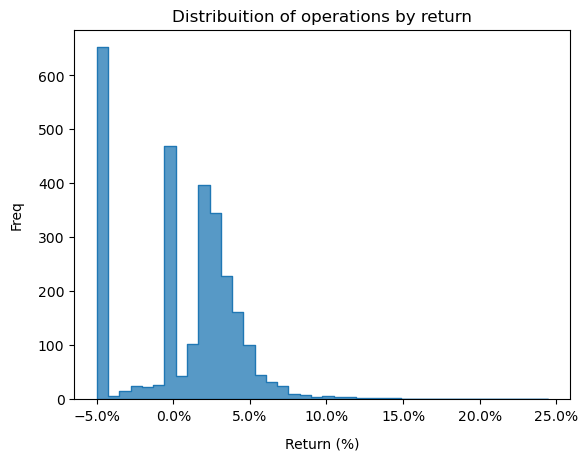

In [28]:
ax = sns.histplot(operation_distance_crisis_classified, x='excess_return', element='step')

ax.set_title('Distribuition of operations by return')
ax.set_xlabel('Return (%)', labelpad=10)
ax.set_ylabel('Freq', labelpad=10)

#Y axis as percentage
ax.xaxis.set_major_formatter(PercentFormatter(1.0));

In [18]:
operation_distance_crisis_classified[operation_distance_crisis_classified['is_bear_market'] == 1]['excess_return'].describe()

count    390.000000
mean       0.008389
std        0.040569
min       -0.050000
25%       -0.029359
50%        0.018776
75%        0.034404
max        0.149781
Name: excess_return, dtype: float64

In [19]:
operation_distance_crisis_classified[operation_distance_crisis_classified['is_bear_market'] == 0]['excess_return'].describe()

count    2355.000000
mean        0.005093
std         0.036546
min        -0.050000
25%        -0.022541
50%         0.016312
75%         0.028792
max         0.244459
Name: excess_return, dtype: float64

## Cointegration method

In [20]:
operation_cointegration_crisis_classified = pd.read_csv("../cointegration_results/operations_crisis_classified.csv")
operation_cointegration_crisis_classified

,Unnamed: 0,Operação,Semestre,Abertura,Fechamento,Dias,Retorno total,Ticker 1,Ticker 2,Converged,Index,Retorno total - exp,date,is_bear_market
0,0,1,0,291,305,14,0.048349,291784Q,ZRN,True,291784Q-ZRN-1,1.049537,1991-03-01,0
1,1,2,0,310,322,12,0.032100,291784Q,ZRN,True,291784Q-ZRN-2,1.032621,1991-03-28,0
2,2,3,0,328,334,6,0.015747,291784Q,ZRN,True,291784Q-ZRN-3,1.015872,1991-04-23,0
3,3,4,0,336,338,2,0.026457,291784Q,ZRN,True,291784Q-ZRN-4,1.026810,1991-05-03,0
4,4,5,0,350,359,9,0.007150,291784Q,ZRN,True,291784Q-ZRN-5,1.007175,1991-05-23,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3642,3642,5,48,5131,5151,20,-0.002430,COF,LH,True,COF-LH-5,0.997573,2010-06-14,0
3643,3643,6,48,5157,5161,4,0.030721,COF,LH,True,COF-LH-6,1.031197,2010-07-21,0
3644,3644,1,48,5041,5070,29,0.184266,CAT,ICE,True,CAT-ICE-1,1.202336,2010-02-04,0
3645,3645,2,48,5146,5167,21,-0.043564,CAT,ICE,False,CAT-ICE-2,0.957372,2010-07-06,0


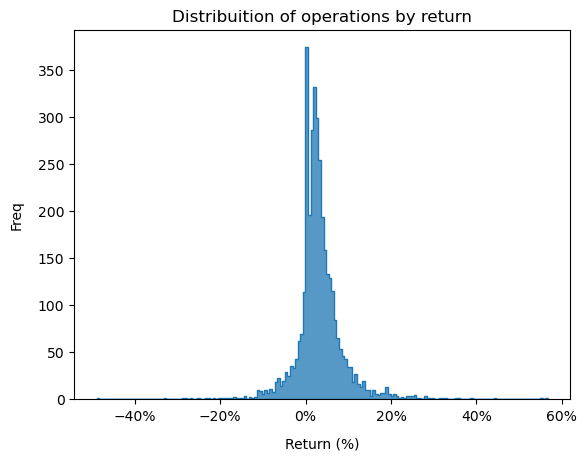

In [29]:
ax = sns.histplot(operation_cointegration_crisis_classified, x='excess_return', element='step')

ax.set_title('Distribuition of operations by return')
ax.set_xlabel('Return (%)', labelpad=10)
ax.set_ylabel('Freq', labelpad=10)

#Y axis as percentage
ax.xaxis.set_major_formatter(PercentFormatter(1.0));

In [24]:
operation_cointegration_crisis_classified[operation_cointegration_crisis_classified['is_bear_market'] == 1]['excess_return'].describe()

count    678.000000
mean       0.045566
std        0.077828
min       -0.488542
25%        0.006556
50%        0.038629
75%        0.077194
max        0.566708
Name: excess_return, dtype: float64

In [25]:
operation_cointegration_crisis_classified[operation_cointegration_crisis_classified['is_bear_market'] == 0]['excess_return'].describe()

count    2969.000000
mean        0.027347
std         0.052324
min        -0.331093
25%         0.003961
50%         0.023076
75%         0.044570
max         0.440748
Name: excess_return, dtype: float64

### Comparison

In [44]:
comparison_markets_distance = operation_distance_crisis_classified.groupby('is_bear_market')['excess_return'].agg(['mean', 'std']).reset_index()
comparison_markets_distance['method'] = 'Distance'
comparison_markets_distance

,is_bear_market,mean,std,method
0,0,0.005093,0.036546,Distance
1,1,0.008389,0.040569,Distance


In [45]:
comparison_markets_cointegration = operation_cointegration_crisis_classified.groupby('is_bear_market')['excess_return'].agg(['mean', 'std']).reset_index()
comparison_markets_cointegration['method'] = 'Cointegration'
comparison_markets_cointegration

,is_bear_market,mean,std,method
0,0,0.027347,0.052324,Cointegration
1,1,0.045566,0.077828,Cointegration


In [46]:
comparison_markets = pd.concat([comparison_markets_distance, comparison_markets_cointegration])
comparison_markets = comparison_markets.replace(0, 'Non-Crisis')
comparison_markets = comparison_markets.replace(1, 'Crisis')
comparison_markets

,is_bear_market,mean,std,method
0,Non-Crisis,0.005093,0.036546,Distance
1,Crisis,0.008389,0.040569,Distance
0,Non-Crisis,0.027347,0.052324,Cointegration
1,Crisis,0.045566,0.077828,Cointegration


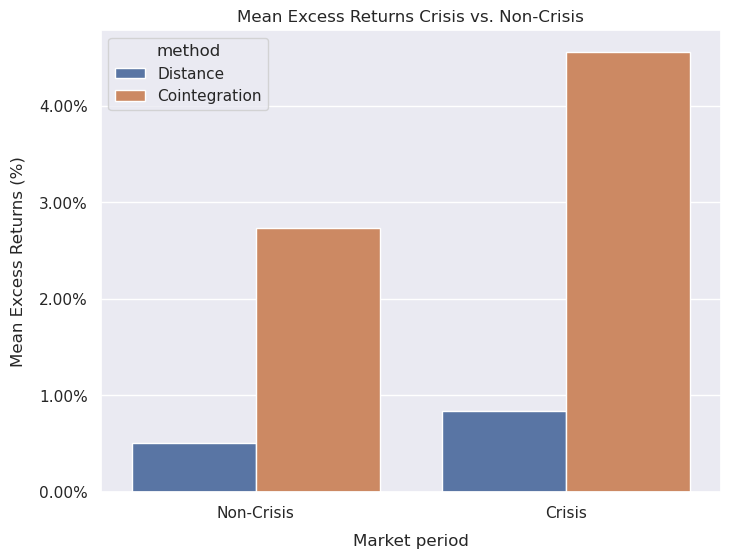

In [53]:
sns.set_theme(style='darkgrid')
fig, ax = plt.subplots(figsize=(8, 6))

ax = sns.barplot(comparison_markets, x='is_bear_market', y='mean', hue='method')

ax.set_title('Mean Excess Returns Crisis vs. Non-Crisis')
ax.set_xlabel('Market period', labelpad=10)
ax.set_ylabel('Mean Excess Returns (%)', labelpad=10)

# Y axis as percentage
ax.yaxis.set_major_formatter(PercentFormatter(1.00))

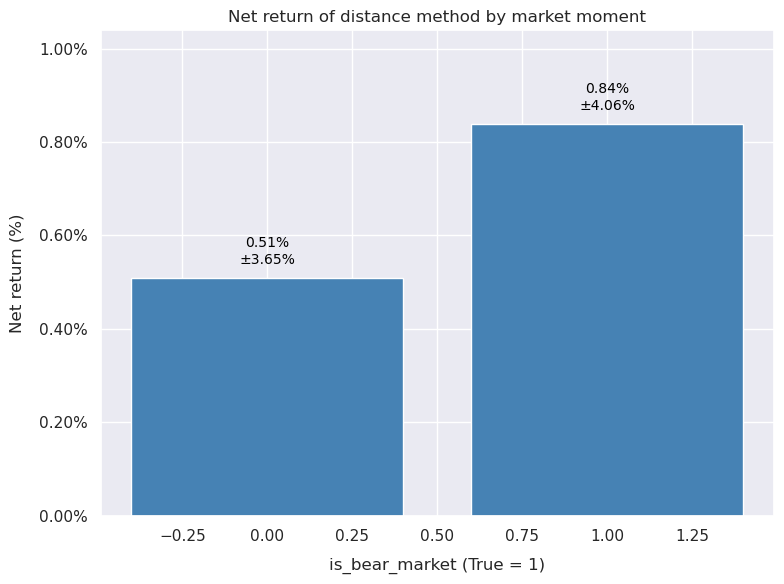

In [15]:
comparison_markets_distance = operation_distance_crisis_classified.groupby('is_bear_market')['Return'].agg(['mean', 'std']).reset_index()

comparison_markets_distance['mean_net'] = comparison_markets_distance['mean'] - 1
comparison_markets_distance['std_net'] = comparison_markets_distance['std']

#Plot data
sns.set_theme(style='darkgrid')
fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(
    comparison_markets_distance['is_bear_market'],
    comparison_markets_distance['mean_net'],
    capsize=5,
    color='steelblue'
)

#Values in the bars
for bar, mean_net, std_net in zip(bars, comparison_markets_distance['mean_net'], comparison_markets_distance['std_net']):
    height = bar.get_height()
    ax.annotate(f'{mean_net:.2%}\n±{std_net:.2%}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 8),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=10, color='black')

ax.set_title('Net return of distance method by market moment')
ax.set_xlabel('is_bear_market (True = 1)', labelpad=10)
ax.set_ylabel('Net return (%)', labelpad=10)
ax.set_ylim(0, comparison_markets_distance['mean_net'].max() + 0.002)

#Y axis as percentage
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

plt.tight_layout()
plt.show()

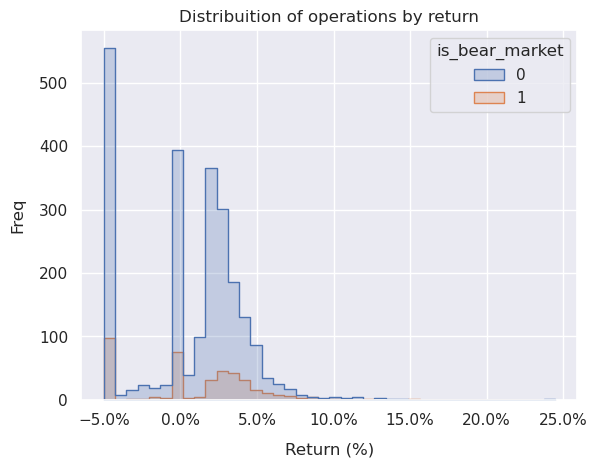

In [16]:
operation_distance_crisis_classified['excess_return'] = operations_distance['Return'] - 1

ax = sns.histplot(operation_distance_crisis_classified, x='excess_return', hue='is_bear_market', element='step')

ax.set_title('Distribuition of operations by return')
ax.set_xlabel('Return (%)', labelpad=10)
ax.set_ylabel('Freq', labelpad=10)

#Y axis as percentage
ax.xaxis.set_major_formatter(PercentFormatter(1.0));